<a href="https://colab.research.google.com/gist/Mindbender66/99d45be9496efbab751ad716f27b2f57/valmiki-sarath-kumar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

**DataSet description**

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [ ]:
d = pd.read_csv('/content/drive/MyDrive/Fraud.csv')

In [ ]:
d.head()

In [ ]:
d.isnull().sum()

In [ ]:
d.duplicated().sum()

In [ ]:
d.describe()

In [ ]:
d.info()

In [ ]:
d["isFraud"].value_counts()

In [ ]:
notfraud = d[d.isFraud == 0]
fraud = d[d.isFraud == 1]

In [ ]:
print(notfraud.shape)
print(fraud.shape)

(6354407, 11)
(8213, 11)


In [ ]:
fraud.amount.describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

In [ ]:
notfraud.amount.describe()

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

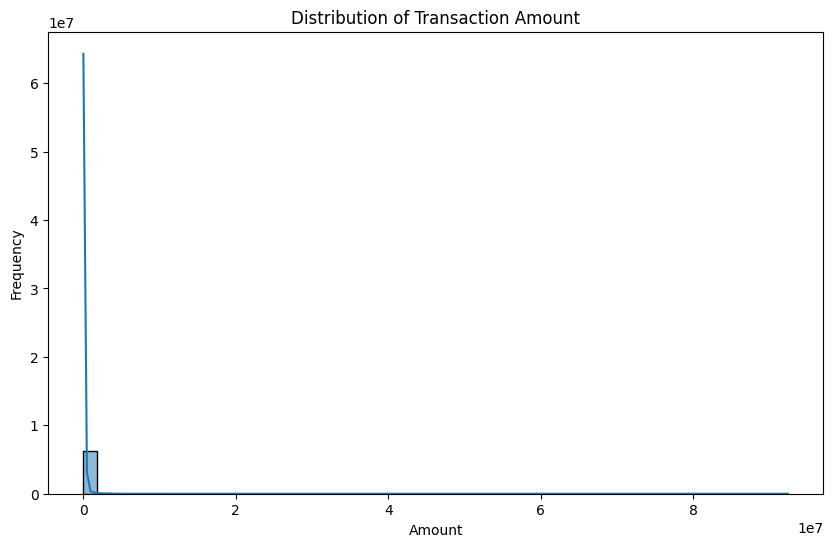

In [ ]:
# Distribution of 'amount'
plt.figure(figsize=(10, 6))
sns.histplot(d['amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

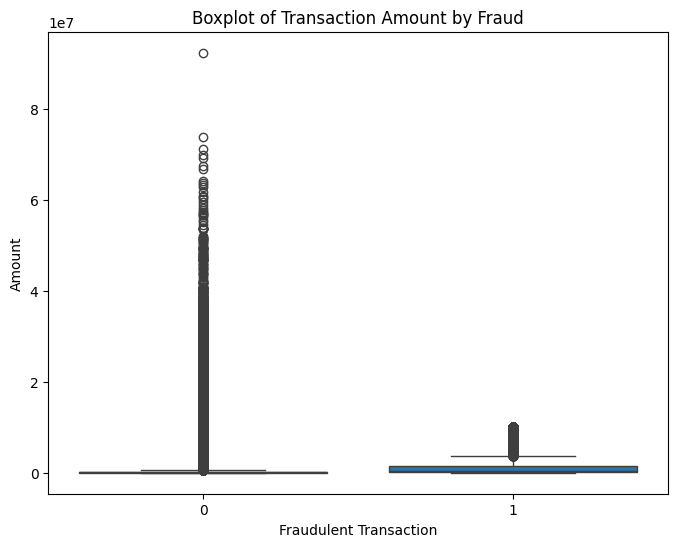

In [ ]:
# Boxplot of 'amount' by 'isFraud'
plt.figure(figsize=(8, 6))
sns.boxplot(x='isFraud', y='amount', data=d)
plt.title('Boxplot of Transaction Amount by Fraud')
plt.xlabel('Fraudulent Transaction')
plt.ylabel('Amount')
plt.show()

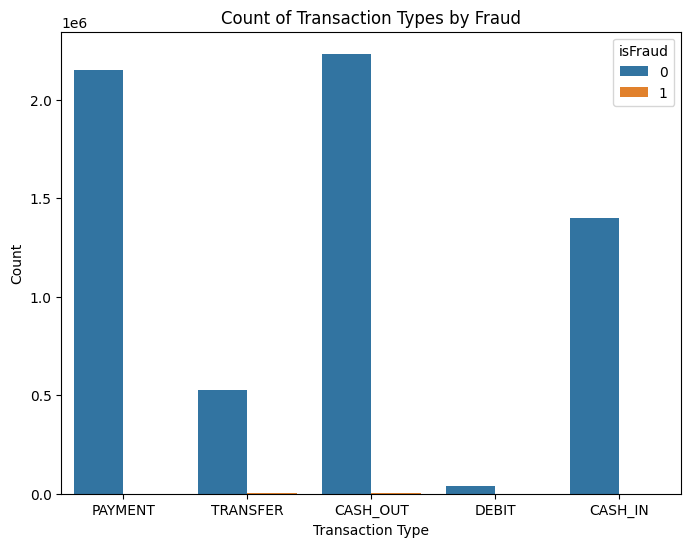

In [ ]:
# Count plot of 'type'
plt.figure(figsize=(8, 6))
sns.countplot(x='type', data=d, hue='isFraud')
plt.title('Count of Transaction Types by Fraud')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

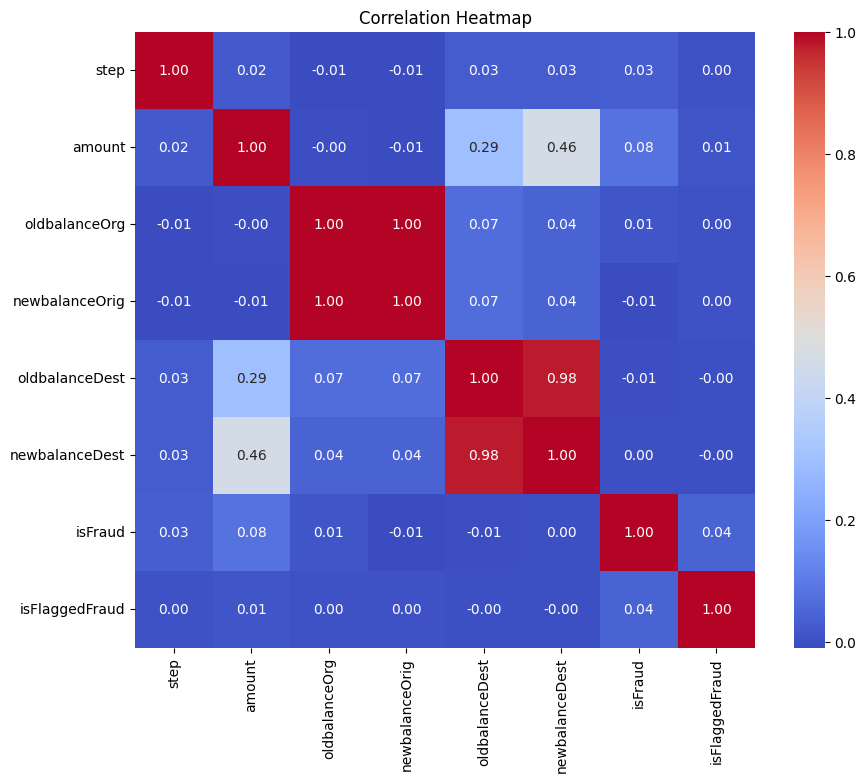

In [ ]:
# Correlation heatmap (excluding non-numeric columns)
numeric = d.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

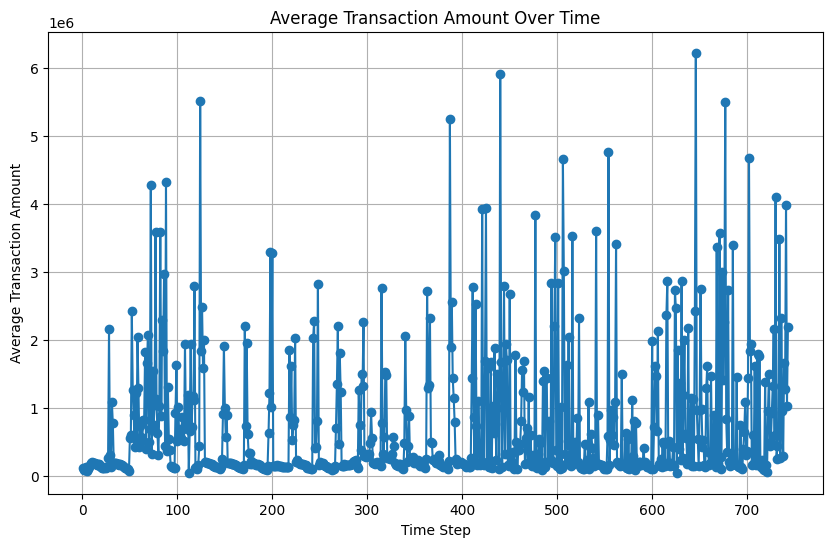

In [ ]:
amount_by_step = d.groupby('step')['amount'].mean()

# Plot line graph
plt.figure(figsize=(10, 6))
plt.plot(amount_by_step.index, amount_by_step.values, marker='o', linestyle='-')
plt.title('Average Transaction Amount Over Time')
plt.xlabel('Time Step')
plt.ylabel('Average Transaction Amount')
plt.grid(True)
plt.show()

In [ ]:
import plotly.express as px
# Group by 'step' and calculate the mean of transaction amounts
amount_by_step = d.groupby('step')['amount'].mean().reset_index()

# Plot line graph using Plotly Express
fig = px.line(amount_by_step, x='step', y='amount', title='Average Transaction Amount Over Time')
fig.update_layout(xaxis_title='Time Step', yaxis_title='Average Transaction Amount')
fig.show()

Outliers using Z-score method: [5106110, 5835554, 6291460, 208414, 5106111, 5835555, 5767181, 5767182, 5106112, 5835556, 1146272, 4194322, 4194323, 4194324, 5106113, 5835557, 5767191, 5835558, 5106114, 3670041, 5835559, 6291486, 6291487, 5106115, 5835560, 5106116, 5835561, 5106117, 3670057, 3670059, 5835562, 5106118, 5835563, 5106119, 5835564, 5106120, 5835565, 5106121, 5835566, 5106122, 1042076, 5767236, 5835567, 5106123, 5767241, 5835568, 5106124, 4194382, 5835569, 5106125, 4718674, 5242963, 5835570, 5106126, 5242964, 84, 88, 5835571, 5106127, 4209775, 6291546, 89, 5835572, 5106128, 94, 96, 4194403, 5106129, 5835573, 1572964, 3670119, 3670120, 5242985, 5106130, 6291563, 5835574, 5835575, 5106131, 1572974, 3145839, 113, 5835576, 5106132, 5242997, 5835577, 5106133, 4705774, 5835578, 5106134, 6291584, 5835579, 5106135, 3145859, 2292565, 4194433, 5835580, 5106136, 4718723, 6291590, 5835581, 5106137, 2097292, 4718734, 3334478, 5835582, 5106138, 5835583, 5106139, 1573018, 5106140, 5835584,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



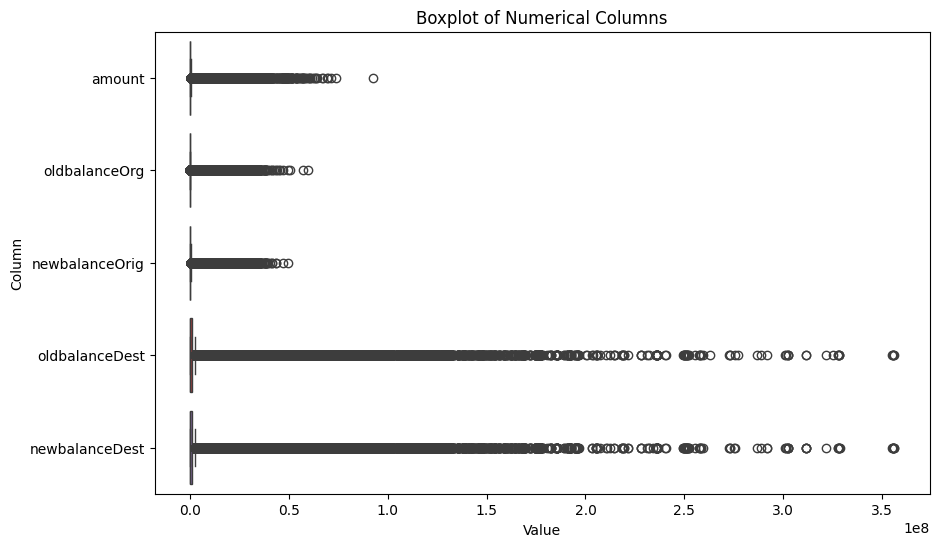

In [ ]:
# Select numerical columns for outlier analysis
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Outlier Analysis using Z-score
def detect_outliers_zscore(data):
    outliers = []
    threshold = 3
    for col in data.columns:
        z_scores = np.abs((data[col] - data[col].mean()) / data[col].std())
        outliers.extend(data[z_scores > threshold][col].index)
    return list(set(outliers))

outliers_zscore = detect_outliers_zscore(d[numerical_cols])
print("Outliers using Z-score method:", outliers_zscore)

# Outlier Analysis using IQR (Interquartile Range)
def detect_outliers_iqr(data):
    outliers = []
    for col in data.columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers.extend(data[(data[col] < lower_bound) | (data[col] > upper_bound)][col].index)
    return list(set(outliers))

outliers_iqr = detect_outliers_iqr(d[numerical_cols])
print("Outliers using IQR method:", outliers_iqr)

# Visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=d[numerical_cols], orient="h")
plt.title('Boxplot of Numerical Columns')
plt.xlabel('Value')
plt.ylabel('Column')
plt.show()

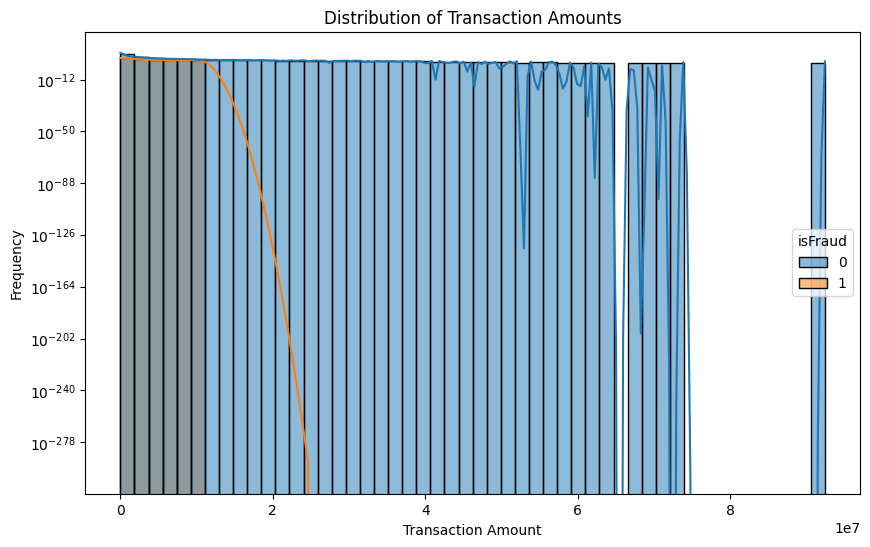

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
plt.figure(figsize=(10, 6))
sns.histplot(data=d, x='amount', hue='isFraud', kde=True, bins=50)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.yscale('log')  # Use log scale for better visualization of distribution
plt.show()

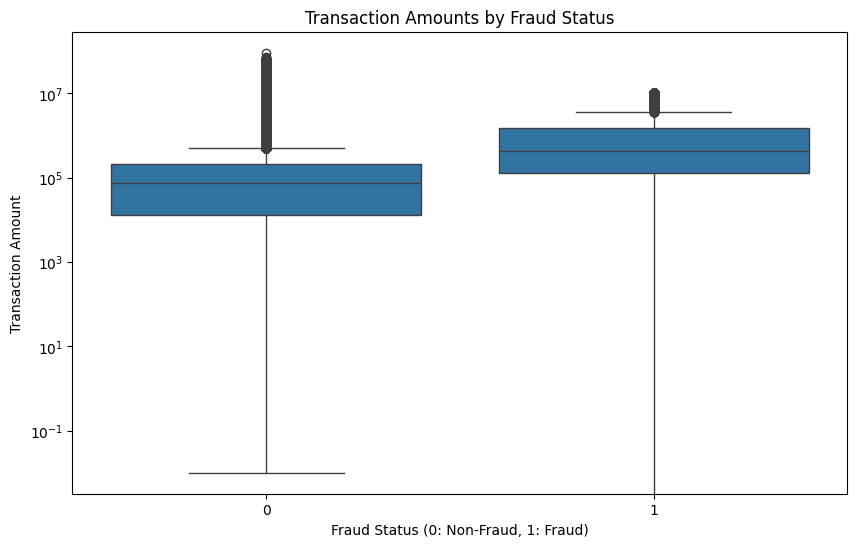

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=d, x='isFraud', y='amount')
plt.title('Transaction Amounts by Fraud Status')
plt.xlabel('Fraud Status (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Transaction Amount')
plt.yscale('log')  # Use log scale for better visualization
plt.show()

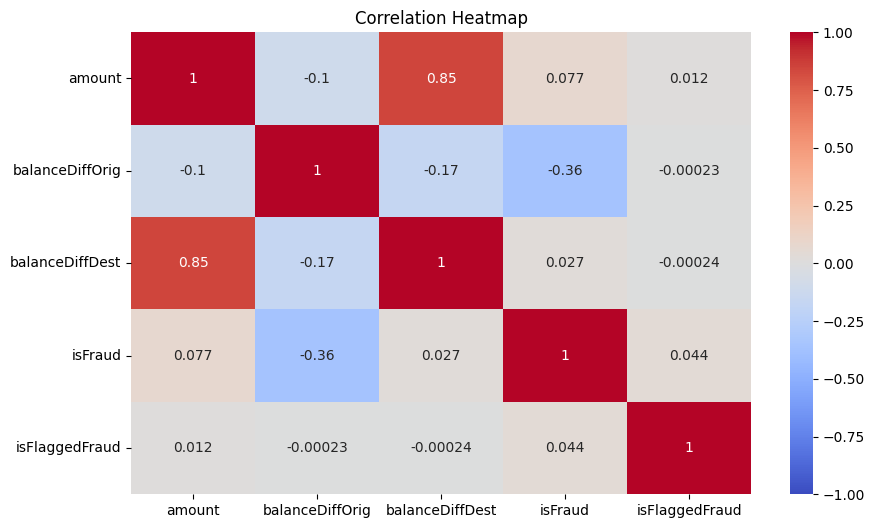

In [ ]:
plt.figure(figsize=(10, 6))
corr = d[['amount', 'balanceDiffOrig', 'balanceDiffDest', 'isFraud', 'isFlaggedFraud']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

<ipython-input-34-045d1328e109>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




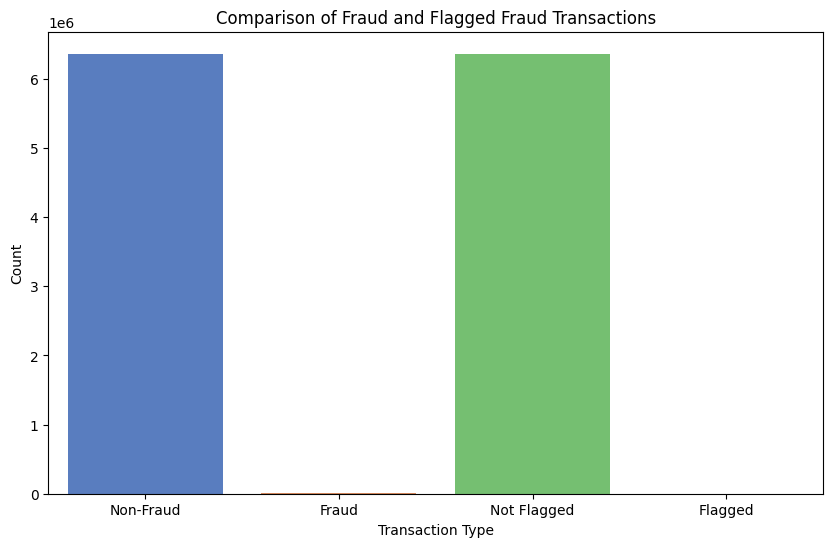

In [ ]:
fraud_counts = d['isFraud'].value_counts()
flagged_fraud_counts = d['isFlaggedFraud'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=['Non-Fraud', 'Fraud', 'Not Flagged', 'Flagged'], y=[fraud_counts[0], fraud_counts[1], flagged_fraud_counts[0], flagged_fraud_counts[1]], palette='muted')
plt.title('Comparison of Fraud and Flagged Fraud Transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

**Feature Engineeing**

**Feature Extraction**

Example: Create a new feature 'balanceDiff' representing the difference between old and new balances for both Origin and Destination

In [ ]:
d['balanceDiffOrig'] = d['newbalanceOrig'] - d['oldbalanceOrg']
d['balanceDiffDest'] = d['newbalanceDest'] - d['oldbalanceDest']

In [ ]:
d.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,-9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,-1864.28,0.0


In [ ]:
# Apply LabelEncoder to 'type' column
label_encoder = LabelEncoder()
d['type'] = label_encoder.fit_transform(d['type'])
d['nameOrig'] = label_encoder.fit_transform(d['nameOrig'])
d['nameDest'] = label_encoder.fit_transform(d['nameDest'])

In [ ]:
d.head(6)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0,-9839.64,0.0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0,-1864.28,0.0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0,-181.00,0.0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0,-181.00,-21182.0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0,-11668.14,0.0
5,1,3,7817.71,6026525,53860.0,46042.29,2247218,0.0,0.0,0,0,-7817.71,0.0


In [ ]:
d['type'].value_counts()

type
1    2237500
3    2151495
0    1399284
4     532909
2      41432
Name: count, dtype: int64

**Feature Selection**

In [ ]:
X = d.drop(columns=["isFraud", "isFlaggedFraud"])
y = d["isFraud"]
selector = SelectKBest(score_func=f_classif, k=6)
X_selected = selector.fit_transform(X, y)
selected_feature = X.columns[selector.get_support()]
print("Selected Features:", selected_feature)

Selected Features: Index(['step', 'type', 'amount', 'nameDest', 'balanceDiffOrig',
       'balanceDiffDest'],
      dtype='object')


In [ ]:
d["isFlaggedFraud"].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [ ]:
d["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [ ]:
data = d[['step', 'type', 'amount', 'nameDest', 'balanceDiffOrig','balanceDiffDest','isFraud','isFlaggedFraud']]

In [ ]:
data = pd.DataFrame(data)

**Select features and target**

In [ ]:
X = data.drop(['isFraud','isFlaggedFraud'], axis=1)
y = data['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

 **ANN model**

**Training and Evaluation**

In [ ]:
model = Sequential()
model.add(Dense(units=16, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.2)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/2
127253/127253 [==============================] - 324s 3ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.0028 - val_accuracy: 0.9994
Epoch 2/2
39767/39767 [==============================] - 59s 1ms/step - loss: 0.0024 - accuracy: 0.9995
Test Accuracy: 99.95%


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}
ANN_metrics = pd.DataFrame([metrics], index=['ANN Model'])
print(ANN_metrics)

           Accuracy  Precision    Recall  F1-score
ANN Model  0.999523   0.940818  0.667284  0.780787


**Classification report and Confusion matrix**

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.94      0.67      0.78      1620

    accuracy                           1.00   1272524
   macro avg       0.97      0.83      0.89   1272524
weighted avg       1.00      1.00      1.00   1272524



**Accuracy and Loss Graphs**

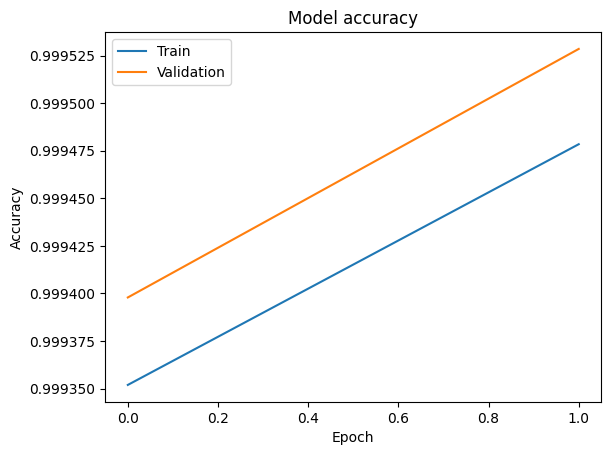

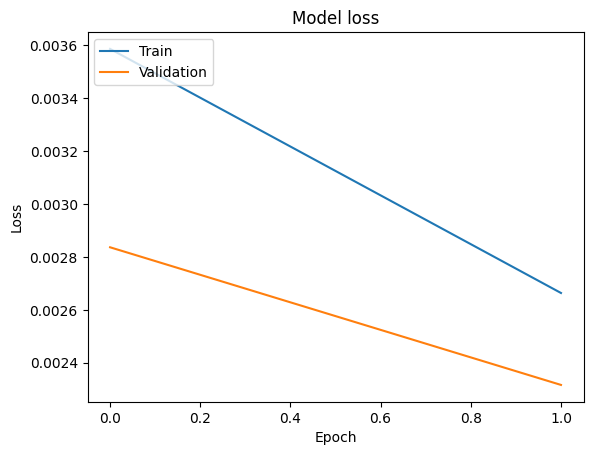

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**ROC curve and AUC**

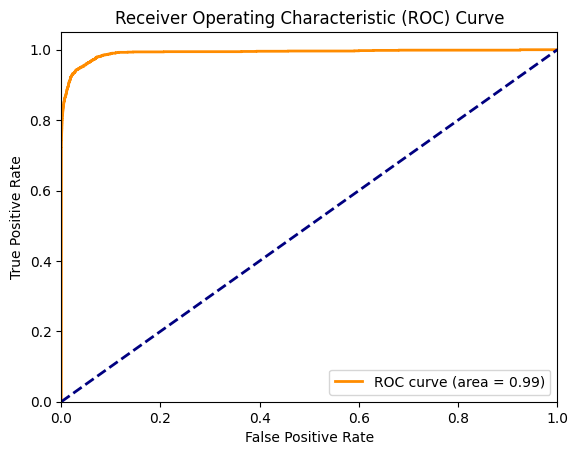

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

**Logistic Regression**

In [ ]:
LR = LogisticRegression()
Model = LR.fit(X_train,y_train)
LR_pred = Model.predict(X_test)
accuracy = accuracy_score(y_test, LR_pred)
precision = precision_score(y_test, LR_pred)
recall = recall_score(y_test, LR_pred)
f1 = f1_score(y_test, LR_pred)
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}
LR_metrics = pd.DataFrame([metrics], index=['Logistic Regression'])
print(LR_metrics)

                     Accuracy  Precision    Recall  F1-score
Logistic Regression  0.999233   0.880615  0.459877  0.604217


In [ ]:
print("Classification Report:")
print(classification_report(y_test, LR_pred))
conf_matrix = confusion_matrix(y_test, LR_pred)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.88      0.46      0.60      1620

    accuracy                           1.00   1272524
   macro avg       0.94      0.73      0.80   1272524
weighted avg       1.00      1.00      1.00   1272524



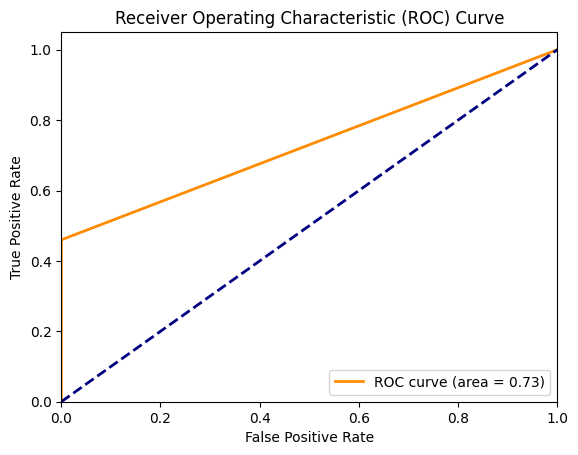

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, LR_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

**Decision Tree**

In [ ]:
DT = DecisionTreeClassifier()
Model1 = DT.fit(X_train, y_train)
DT_pred = Model1.predict(X_test)
accuracy = accuracy_score(y_test, DT_pred)
precision = precision_score(y_test, DT_pred)
recall = recall_score(y_test, DT_pred)
f1 = f1_score(y_test, DT_pred)
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}
DT_metrics = pd.DataFrame([metrics], index=['Decision Tree'])
print(DT_metrics)

               Accuracy  Precision   Recall  F1-score
Decision Tree  0.999452   0.789342  0.77716  0.783204


In [ ]:
print("Classification Report:")
print(classification_report(y_test, DT_pred))
conf_matrix = confusion_matrix(y_test, DT_pred)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.79      0.78      0.78      1620

    accuracy                           1.00   1272524
   macro avg       0.89      0.89      0.89   1272524
weighted avg       1.00      1.00      1.00   1272524



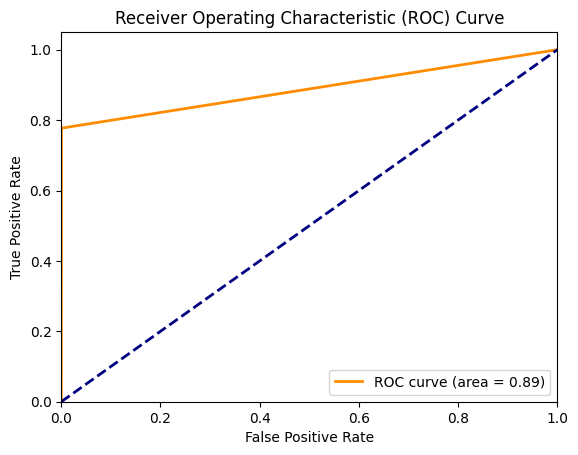

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, DT_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

**Support Vector Machine**

In [ ]:
SVM = SVC(kernel='linear')
Model2 = SVM.fit(X_train, y_train)
SVM_pred = Model2.predict(X_test)
accuracy = accuracy_score(y_test, SVM_pred)
precision = precision_score(y_test, SVM_pred)
recall = recall_score(y_test, SVM_pred)
f1 = f1_score(y_test, SVM_pred)
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}
SVC_metrics = pd.DataFrame([metrics], index=['Support Vector Classifier'])
print(SVC_metrics )

In [ ]:
print("Classification Report:")
print(classification_report(y_test, SVM_pred))
conf_matrix = confusion_matrix(y_test, SVM_pred)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, SVM_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

**Navie Bayes Gaussian**

In [ ]:
#x_train_dense = X_train.toarray()
#x_test_dense = X_test.toarray()
NB_Gaussian = GaussianNB()
Model3 = NB_Gaussian.fit(X_train, y_train)
NB_pred = Model3.predict(X_test)
accuracy = accuracy_score(y_test, NB_pred)
precision = precision_score(y_test, NB_pred)
recall = recall_score(y_test, NB_pred)
f1 = f1_score(y_test, NB_pred)
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}
NB_metrics = pd.DataFrame([metrics], index=['Navie Bayes Gaussian'])
print(NB_metrics )

                      Accuracy  Precision    Recall  F1-score
Navie Bayes Gaussian   0.99046   0.065289  0.487654   0.11516


In [ ]:
print("Classification Report:")
print(classification_report(y_test, NB_pred))
conf_matrix = confusion_matrix(y_test, NB_pred)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270904
           1       0.07      0.49      0.12      1620

    accuracy                           0.99   1272524
   macro avg       0.53      0.74      0.56   1272524
weighted avg       1.00      0.99      0.99   1272524



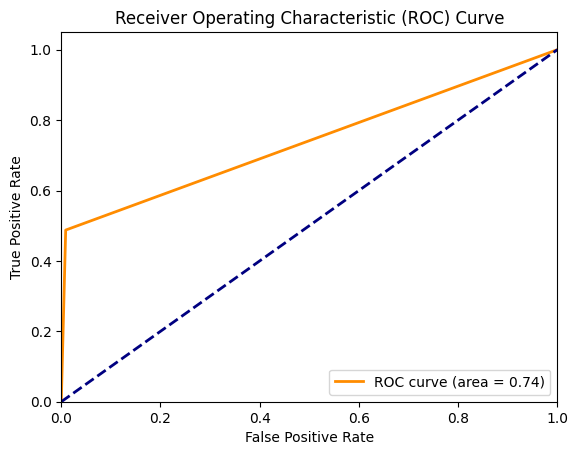

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, NB_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

**XGBoost**

In [ ]:
# XGBoost classifier
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)
xgb_predictions = xgb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, xgb_predictions)
precision = precision_score(y_test, xgb_predictions)
recall = recall_score(y_test, xgb_predictions)
f1 = f1_score(y_test, xgb_predictions)
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}
XGB_metrics = pd.DataFrame([metrics], index=['XGBoost'])
print(XGB_metrics )

         Accuracy  Precision    Recall  F1-score
XGBoost  0.999629   0.971264  0.730247  0.833686


In [ ]:
print("Classification Report:")
print(classification_report(y_test, xgb_predictions))
conf_matrix = confusion_matrix(y_test, xgb_predictions)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.97      0.73      0.83      1620

    accuracy                           1.00   1272524
   macro avg       0.99      0.87      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524



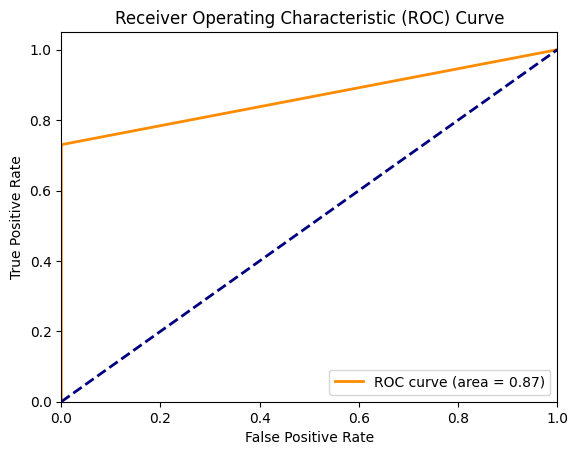

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, xgb_predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

**Plot confusion matrix**

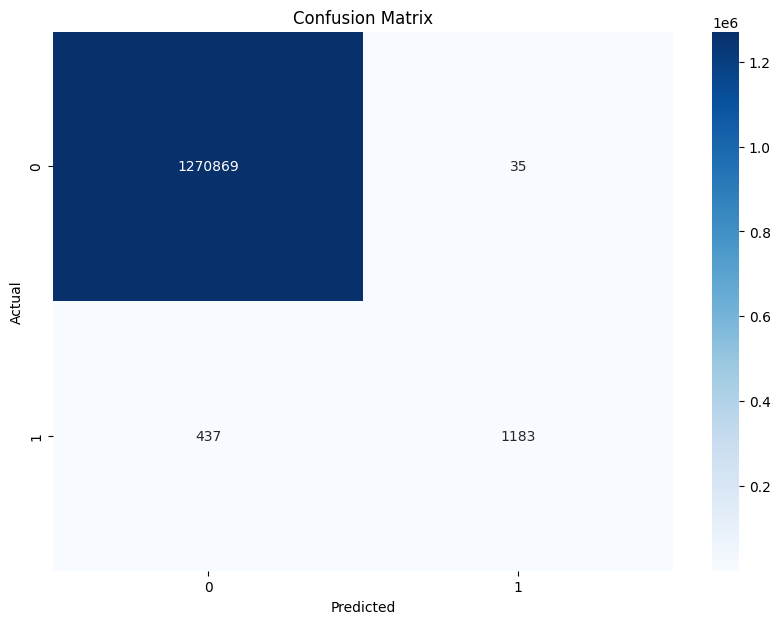

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**ROC curve and AUC**

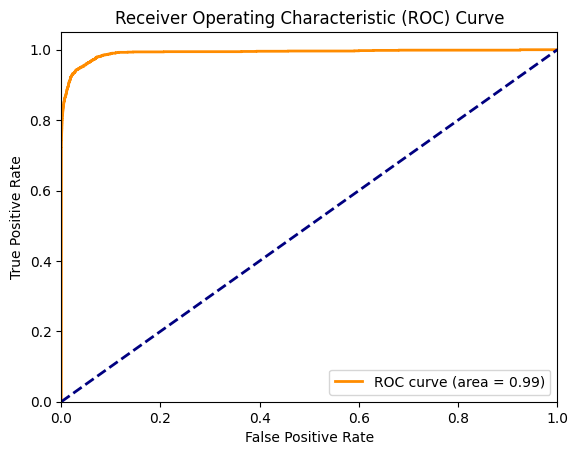

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
pip install joblib


In [ ]:
import joblib
joblib.dump(Model1, 'decision_tree_model.pkl')

['decision_tree_model.pkl']

**'step', 'type', 'amount', 'nameDest', 'balanceDiffOrig','balanceDiffDest' These need to be Input**